In [170]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

In [171]:
# Step 1: Get S&P 500 ticker symbols
df = pd.read_csv(r"C:\Users\mamun\Downloads\S&P 500 Companies (Standard and Poor 500) - basics.csv")
sp500_tickers = df['Symbol'].tolist()

In [172]:
# Step 2: Download historical price data
def safe_download(ticker, start, end):
    try:
        # Redirect stderr to null to suppress errors
        sys.stderr = open(os.devnull, 'w')
        data = yf.download(ticker, start=start, end=end, progress=False)
        return data
    finally:
        # Reset stderr
        sys.stderr = sys.__stderr__
    return None
    
data = safe_download(sp500_tickers, start='2022-01-01', end='2023-01-01')['Adj Close']
data = data.dropna(axis=1, how='all')

In [173]:
# Step 3: Calculate log returns
log_returns = np.log(data / data.shift(1)).dropna(axis=0, how='all')

In [174]:
# Step 4: Calculate correlation matrix
correlation_matrix = log_returns.corr()

In [175]:
# Step 5: Visualize the correlation matrix
#plt.figure(figsize=(12, 10))
#sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
#plt.title("Correlation Matrix of S&P 500 Stocks (Log Returns)")
#plt.show()

In [176]:
# Step 6: Identify pairs with low correlation
low_corr_pairs = correlation_matrix[(correlation_matrix.abs() < 0.3) & (correlation_matrix != 1.0)]
low_corr_pairs.index.names = [None]

# Stack and reset the index
low_corr_pairs = low_corr_pairs.stack().reset_index()
    
# Rename the columns manually
low_corr_pairs.columns = ['Stock_1', 'Stock_2', 'Correlation']
    
# Sort each pair alphabetically
sorted_pairs = low_corr_pairs[['Stock_1', 'Stock_2']].apply(lambda x: sorted(x), axis=1)
low_corr_pairs['Stock_1'] = sorted_pairs.apply(lambda x: x[0])
low_corr_pairs['Stock_2'] = sorted_pairs.apply(lambda x: x[1])

# Remove duplicate pairs
low_corr_pairs = low_corr_pairs.drop_duplicates(subset=['Stock_1', 'Stock_2'])

# Round the correlation column to 3 decimal places
low_corr_pairs['Correlation'] = low_corr_pairs['Correlation'].round(4)

# Sort by correlation value
low_corr_pairs = low_corr_pairs.reindex(
    low_corr_pairs['Correlation'].abs().sort_values(ascending=True).index
)

# Print result
#print("Pairs of stocks with low correlation:")
#print(low_corr_pairs.to_string(index=False))

In [177]:
# Step 7: Choose what stocks to buy
buy_list = []
for _, row in low_corr_pairs.head(10).iterrows():
    # Append Stock_1 if not already in the list
    if row['Stock_1'] not in buy_list:
        buy_list.append(row['Stock_1'])
    
    # Append Stock_2 if not already in the list
    if row['Stock_2'] not in buy_list:
        buy_list.append(row['Stock_2'])

print("Unique tickers from top 10 pairs:", buy_list)

Unique tickers from top 10 pairs: ['NU', 'SJM', 'BMY', 'DVA', 'BMC', 'TSN', 'APH', 'STI', 'ANR', 'AZO', 'TDC', 'APA', 'HPQ', 'YUM', 'NRG', 'POM']


In [178]:
def prepare_data(ticker):
    data = pd.DataFrame(safe_download(ticker, start='2023-01-01', end='2024-01-01'))
    data["SMA"] = data["Adj Close"].rolling(30).mean()
    data["Lower"] = data["SMA"] - data["Adj Close"].rolling(30).std() * 2
    data["Upper"] = data["SMA"] + data["Adj Close"].rolling(30).std() * 2
    data['Log Returns'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))
    
    # Calculate momentum indicators
    window = 14
    delta = data['Adj Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))
    
    data['ROC'] = data['Adj Close'].pct_change(10)
    
    # Volume-based indicator
    data['Avg_Volume'] = data['Volume'].rolling(window=20).mean()
    
    return data

In [179]:
# Step 9: Testing strategy and the positions
def test_strategy(ticker, momentum_weight=2, rsi_threshold=70, roc_threshold=0.05, volume_multiplier=1.5):
    data = prepare_data(ticker)
    
    # Bollinger Bands strategy
    data['Distance'] = data['Adj Close'] - data['SMA']
    data['BB_Position'] = np.where(data['Adj Close'] < data['Lower'], 1, np.nan)
    data['BB_Position'] = np.where(data['Adj Close'] > data['Upper'], -1, data['BB_Position'])
    data['BB_Position'] = np.where(data['Distance'] * data['Distance'].shift(1) < 0, 0, data['BB_Position'])
    data['BB_Position'] = data['BB_Position'].ffill().fillna(0)

    # Momentum strategy (prioritize RSI & ROC)
    data['Momentum_Position'] = np.where((data['RSI'] > rsi_threshold) & (data['ROC'] > roc_threshold), 1, 
                                         np.where((data['RSI'] < 100 - rsi_threshold) & (data['ROC'] < -roc_threshold), -1, 0))
    
    # Volume-based confirmation
    data['Volume_Signal'] = data['Volume'] > (data['Avg_Volume'] * volume_multiplier)
    
    # Combine all signals for rally confirmation without using MAs
    data['Rally_Signal'] = (
        (data['Momentum_Position'] == 1) &  # Momentum signal is positive
        (data['Volume_Signal'])  # Volume is spiking
    )
    
    data['Rally_Signal'] = np.where(data['Rally_Signal'], 1, 0)  # Use 1 for rallies
    
    # Apply combined position that is weighted by momentum
    weighted_momentum = data['Momentum_Position'] * momentum_weight
    data['Combined_Position'] = np.where(
        data['Rally_Signal'], weighted_momentum,  # Take weighted position if rally signal is positive
        data['BB_Position']  # Otherwise follow Bollinger Bands strategy
    )
    
    # Calculate strategy returns
    data['Strategy'] = data['Combined_Position'].shift(1) * data['Log Returns']
    data.dropna(inplace=True)
    
    # Calculate cumulative strategy returns
    data['Cumulative Strategy'] = data['Strategy'].cumsum().apply(np.exp)
    
    return data['Cumulative Strategy']

In [180]:
# Step 10: Combining the strategy on all the chosen stocks
def combine_strategies(tickers, momentum_weight=2, rsi_threshold=70, roc_threshold=0.05, volume_multiplier=1.5):
    strategies = []

    # Test strategy for each ticker and store the result
    for ticker in tickers:
        strategy = test_strategy(ticker, momentum_weight, rsi_threshold, roc_threshold, volume_multiplier)
        strategies.append(strategy)

    # Combine all strategies into a DataFrame, aligning them by date
    combined_df = pd.concat(strategies, axis=1)

    # Calculate the mean strategy across all stocks
    combined_df['Mean Strategy'] = combined_df.mean(axis=1)

    return combined_df['Mean Strategy']  # Return as a NumPy array

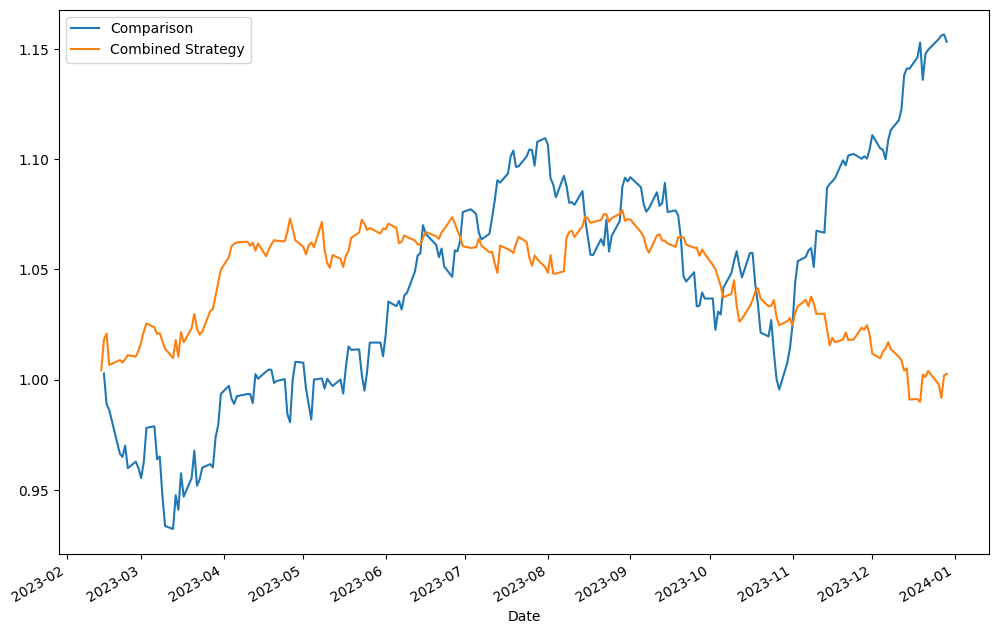

In [181]:
# Step 11: Comparing to the S&P500
metric = pd.DataFrame(safe_download('^GSPC', start='2023-01-01', end='2024-01-01')['Adj Close'])
metric['Log Returns'] = np.log(metric['Adj Close'] / metric['Adj Close'].shift(1))
metric = metric.tail(220)
metric['Cumulative Returns'] = metric['Log Returns'].cumsum().apply(np.exp)
comparison = metric['Cumulative Returns']

# Assuming `comparison` and `combine_strategies(buy_list)` are Pandas Series
comparison_series = pd.Series(comparison)  # Make sure `comparison` is a Series
combined_strategy_series = combine_strategies(buy_list)  # This should already be a Series

# Combine the Series into a DataFrame
df_to_plot = pd.DataFrame({
    'Comparison': comparison_series,
    'Combined Strategy': combined_strategy_series
})

# Plot the DataFrame
df_to_plot.plot(figsize=(12, 8))
plt.show()

In [182]:
# Step 12: Fine-tune strategy
def grid_search(tickers, rsi_values, roc_values, volume_multipliers, momentum_weights):
    results = []

    for rsi in rsi_values:
        for roc in roc_values:
            for vol_mult in volume_multipliers:
                for momentum_w in momentum_weights:
                    # Run the strategy with the current set of parameters on all tickers
                    combined_strategy = combine_strategies(
                        tickers, momentum_weight=momentum_w, 
                        rsi_threshold=rsi, roc_threshold=roc, 
                        volume_multiplier=vol_mult
                    )

                    # Calculate performance metrics
                    total_return = combined_strategy.iloc[-1]
                    sharpe_ratio = combined_strategy.pct_change().mean() / combined_strategy.pct_change().std()
                    max_drawdown = (combined_strategy.cummax() - combined_strategy).max()
                    
                    # Save results
                    results.append({
                        'RSI Threshold': rsi,
                        'ROC Threshold': roc,
                        'Volume Multiplier': vol_mult,
                        'Momentum Weight': momentum_w,
                        'Total Return': total_return,
                        'Sharpe Ratio': sharpe_ratio,
                        'Max Drawdown': max_drawdown
                    })

    # Create a DataFrame of results to analyze
    results_df = pd.DataFrame(results)
    return results_df

# Define parameter ranges
rsi_values = range(60, 80, 5)  # For example, RSI threshold from 60 to 75
roc_values = [0.03, 0.05, 0.07]  # ROC threshold options
volume_multipliers = [1.2, 1.5, 1.8]  # Volume multiplier options
momentum_weights = [1, 2, 3]  # Momentum weights

# Run grid search
#results_df = grid_search(buy_list, rsi_values, roc_values, volume_multipliers, momentum_weights)

# Find the best combination based on Sharpe Ratio
#best_params = results_df.sort_values(by='Sharpe Ratio', ascending=False).iloc[0]
#print("Best parameters:", best_params)

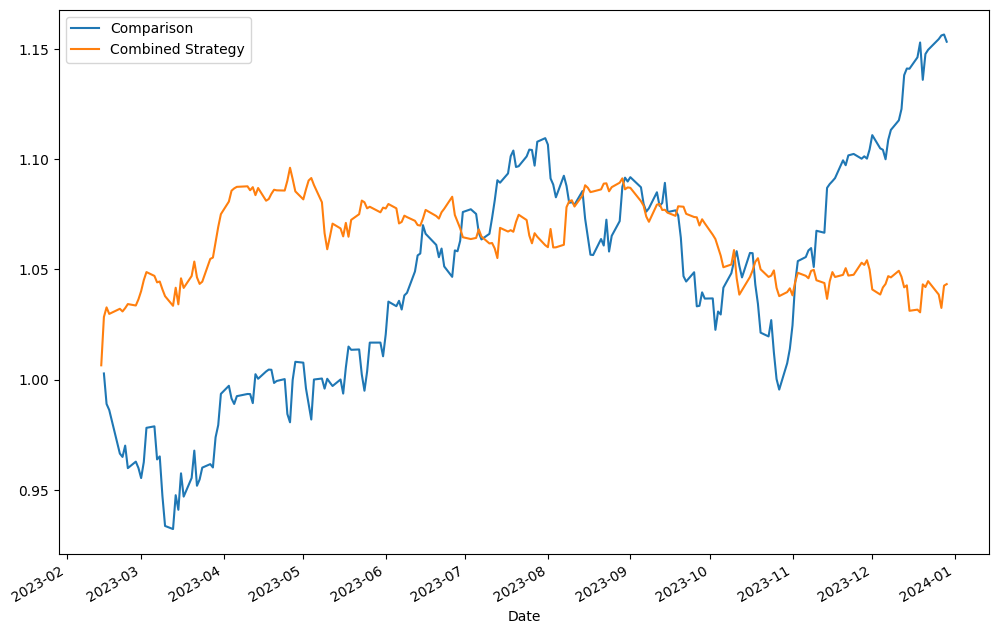

In [183]:
# Step 13: Retest
# Assuming `comparison` and `combine_strategies(buy_list)` are Pandas Series
comparison_series = pd.Series(comparison)  # Make sure `comparison` is a Series
combined_strategy_series = combine_strategies(buy_list, momentum_weight=3, rsi_threshold=75, roc_threshold=0.03, volume_multiplier=1.8)  # This should already be a Series

# Combine the Series into a DataFrame
df_to_plot = pd.DataFrame({
    'Comparison': comparison_series,
    'Combined Strategy': combined_strategy_series
})

# Plot the DataFrame
df_to_plot.plot(figsize=(12, 8))
plt.show()